# Collaborative Topic Regression

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [95]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [92]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import caffeine

## Step 1 : Generate Rating Matrix

In [3]:
# program_df = pd.read_csv("/Users/krishna/Dropbox/Data/Data/Program/correct File/csvwithHeaders/part-00000-024e4c6e-680c-49e1-8e20-667765b52332-c000.csv")
AllData_test_run = pq.read_table("/Users/krishna/Dropbox/Data/final_datasets/feature_enginnering/user_program_features/stage2/part-00000-c8f21366-ffaf-491f-837c-abaa906916b3-c000.snappy.parquet")
AllData_test_run_df = AllData_test_run.to_pandas()
AllData_test_run_df.replace("NULL", np.nan,inplace=True)
# AllData_test_run_df.replace(np.nan, 0,inplace=True)
AllData_test_run_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3494276 entries, 0 to 3494275
Data columns (total 25 columns):
USER                              int64
PROGRAM_WATCH_RATIO               float64
EPISODES_WATCHED                  int64
USER_WATCH_FREQUENCY              float64
USER_PROGRAM_PREFERANCE_METRIC    float64
MASTER_TITLE                      object
EVENT_DATE                        object
CATEGORY_ID                       object
SUBCATEGORY_ID                    object
RUNTIME                           object
EPISODE_COUNT                     object
day                               object
week_text                         object
week_encoded                      object
month                             object
vwp_days                          object
weekend                           object
daypart                           object
weekOfTheYear                     object
EVENT_END_DATE                    object
airStartDate                      object
airStartTime             

### Transpose the original Matrix to for Rating Matrix

In [5]:
AllData_test_run_pivot_df = AllData_test_run_df[["USER","MASTER_TITLE","USER_PROGRAM_PREFERANCE_METRIC"]].pivot("USER", "MASTER_TITLE", "USER_PROGRAM_PREFERANCE_METRIC")
AllData_test_run_pivot_df.replace("NULL", np.nan,inplace=True)
AllData_test_run_pivot_df.replace(np.nan, 0,inplace=True)
AllData_test_run_pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292601 entries, 5046682 to 9145409
Columns: 259 entries, A Taste of History to tasteMAKERS
dtypes: float64(259)
memory usage: 580.4 MB


In [6]:
AllData_test_run_pivot_df_Original = AllData_test_run_pivot_df.copy()

### Making one of the series Blank

In [7]:
AllData_test_run_pivot_df['The Big Bang Theory'] = 0.0
AllData_test_run_pivot_df.head()

## Step 2 : Generate document-term matrix

### Pre-processing:

In [14]:
import pickle
pickle_in = open("data_combined_265_0_articles_Jun24.pickle","rb")
data_combined = pickle.load(pickle_in)

In [16]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

data_clean = pd.DataFrame(data_combined.Data.apply(round1))

# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)
data_clean = pd.DataFrame(data_clean.Data.apply(round2))

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import stem

np.random.seed(2018)
import nltk
nltk.download('wordnet')
stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

# print(preprocess(data_clean['Data'][0]))
data_clean = pd.DataFrame(data_clean.Data.apply(preprocess))

In [20]:
data_clean.head()

,Data
A Taste of History,taste gustatory perception or gustation adject...
ALVINNN!!! and the Chipmunks,alvin and the chipmunks stylized as alvinnn an...
Alaska: The Last Frontier: The Frozen Edge,alaska the last frontier is an american realit...
America Says,america says is an american television game sh...
America's Heartland,americas heartland is a television program in ...


### Custom function for document-term Matrix:

In [12]:
from collections import Counter, defaultdict

import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import reuters, stopwords
from six.moves import xrange


def get_ids_cnt(corpus, max_voca=9999999, remove_top_n=5):
    voca = set(w.lower() for w in nltk.corpus.words.words())
    stop = stopwords.words('english')
    stop.append(['episodes','season','seasons','new','television','tv','series','show','shows'])

    docs = list()
    freq = Counter()

    for doc in corpus:
        if isinstance(doc, str):
            doc = word_tokenize(doc)
        elif not hasattr(doc, '__iter__'):
            raise Exception('Corpus is not a list of string or token list')

        # remove word using stopword list or single character word
        # if word.lower() in voca and
        doc = [word.lower() for word in doc if word.lower() not in stop and len(word) > 2]
        freq.update(doc)
        docs.append(doc)

    voca = [key for iter, (key, val) in enumerate(freq.most_common(max_voca)) if iter >= remove_top_n]

    voca_dic = dict()
    voca_list = list()
    for word in voca:
        voca_dic[word] = len(voca_dic)
        voca_list.append(word)

    doc_ids = list()
    doc_cnt = list()

    for doc in docs:
        words = set(doc)
        ids = np.array([int(voca_dic[word]) for word in words if word in voca_dic])
        cnt = np.array([int(doc.count(word)) for word in words if word in voca_dic])

        doc_ids.append(ids)
        doc_cnt.append(cnt)

    return np.array(voca_list), doc_ids, doc_cnt

def get_top_words(topic_word_matrix, vocab, topic, n_words=20):
    if not isinstance(vocab, np.ndarray):
        vocab = np.array(vocab)
    top_words = vocab[topic_word_matrix[topic].argsort()[::-1][:n_words]]
    return top_words

In [15]:
len(data_combined)

259

In [24]:
voca, doc_ids, doc_cnt = get_ids_cnt(list(data_clean['Data']))

In [25]:
len(voca)

61708

## Step 3 :  CTR - Custom function Declarations
- euclidean_proj_simplex  
- formatted_logger  
- get_ids_cnt  
- CollaborativeTopicModel Class

In [9]:
import numpy as np

def euclidean_proj_simplex(v, s=1):
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n + 1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = (cssv[rho] - s) / (rho + 1.0)
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w

In [10]:
import logging
import os
import time

default_log_path = './logs'


def formatted_logger(label, level=None, format=None, date_format=None, file_path=None):
    log = logging.getLogger(label)
    if level is None:
        level = logging.INFO
    elif level.lower() == 'debug':
        level = logging.DEBUG
    elif level.lower() == 'info':
        level = logging.INFO
    elif level.lower() == 'warn':
        level = logging.WARN
    elif level.lower() == 'error':
        level = logging.ERROR
    elif level.lower() == 'critical':
        level = logging.CRITICAL
    log.setLevel(level)

    if format is None:
        format = '%(asctime)s %(levelname)s:%(name)s:%(message)s'
    if date_format is None:
        date_format = '%Y-%m-%d %H:%M:%S'
    if file_path is None:
        if not os.path.exists(default_log_path):
            os.makedirs(default_log_path)
        file_path = '%s/%s.%s.log.txt' % (default_log_path, label, time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime()))

    formatter = logging.Formatter(format, date_format)
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    file_handler = logging.FileHandler(file_path)
    file_handler.setFormatter(formatter)
    log.addHandler(file_handler)
    log.addHandler(stream_handler)
    return log

In [11]:
from __future__ import print_function
import time

import numpy as np
import numpy.linalg
import scipy.optimize
from six.moves import xrange

logger = formatted_logger('CollaborativeTopicModel', 'info')

e = 1e-100
error_diff = 10

class CollaborativeTopicModel:
    def __init__(self, 
                 n_topic, 
                 n_voca, 
                 n_user, 
                 n_item, 
                 doc_ids, 
                 doc_cnt, 
                 ratings,
                 lambda_u,
                 lambda_v):
        self.lambda_u = lambda_u
        self.lambda_v = lambda_v
        self.alpha = 1
        self.eta = 0.01
        self.a = 1
        self.b = 0.01
        self.verbose = 1

        self.n_topic = n_topic
        self.n_voca = n_voca
        self.n_user = n_user
        self.n_item = n_item

        # U = user_topic matrix, U x K
        self.U = np.random.multivariate_normal(np.zeros(n_topic), np.identity(n_topic) * (1. / self.lambda_u),
                                               size=self.n_user)
        # V = item(doc)_topic matrix, V x K
        self.V = np.random.multivariate_normal(np.zeros(n_topic), np.identity(n_topic) * (1. / self.lambda_v),
                                               size=self.n_item)
        self.theta = np.random.random([n_item, n_topic])
        self.theta = self.theta / self.theta.sum(1)[:, np.newaxis]  # normalize
        self.beta = np.random.random([n_voca, n_topic])
        self.beta = self.beta / self.beta.sum(0)  # normalize

        self.doc_ids = doc_ids
        self.doc_cnt = doc_cnt

        self.C = np.zeros([n_user, n_item]) + self.b
        self.R = np.zeros([n_user, n_item])  # user_size x item_size

        for item in xrange(len(ratings.T)):
            col_mean_val = ratings[:,item].mean()
            for user in xrange(len(ratings)):
                if ratings[user,item] > 0.0 :
                    self.C[user, item] += self.a - self.b
                self.R[user, item] = ratings[user,item]        
        
#         for user in xrange(len(ratings)):
#             col_mean_val = ratings[user,:].mean()
#             for di in xrange(len(ratings[user].T)):
#                 if ratings[user,di] > col_mean_val :
#                     self.C[user, di] += self.a - self.b
#                     self.R[user, di] = 1 # ratings[user,di]

# felt wrong about this logic - rewrote as above for loop
#         for di in xrange(len(ratings)):
#             rate = ratings[di]
#             for user in range(len(rate)):
#                 self.C[user, di] += self.a - self.b
#                 self.R[user, di] = 1                

        self.phi_sum = np.zeros([n_voca, n_topic]) + self.eta

    def fit(self, doc_ids, doc_cnt, rating_matrix, max_iter=100):
        old_err = 0
        for iteration in xrange(max_iter):
            tic = time.clock()
            self.do_e_step()
            self.do_m_step()
            err = self.sqr_error()
            if self.verbose:
                print('[ITER] {:3d},\tElapsed time:{:2f},\tReconstruction error:{:3f}'.format(iteration,time.clock() - tic, err))
            if abs(old_err - err) < error_diff:
                print('Error Value difference is minimized')
                break
            else :
                old_err = err.copy()

    # reconstructing matrix for prediction
    def predict_item(self):
        return np.dot(self.U, self.V.T)

    # reconstruction error
    def sqr_error(self):
        err = (self.R - self.predict_item()) ** 2
        err = err.sum()

        return err

    def do_e_step(self):
        self.update_u()
        self.update_v()
        self.update_theta()

    def update_theta(self):
        def func(x, v, phi, beta, lambda_v):
            return 0.5 * lambda_v * np.dot((v - x).T, v - x) - np.sum(np.sum(phi * (np.log(x * beta) - np.log(phi))))

        for vi in xrange(self.n_item):
            W = np.array(self.doc_ids[vi])
            W = W.astype(int)
            word_beta = self.beta[W, :]
            phi = self.theta[vi, :] * word_beta + e  # W x K
            phi = phi / phi.sum(1)[:, np.newaxis]
            result = scipy.optimize.minimize(func, 
                                             self.theta[vi, :], 
                                             method='nelder-mead',
                                             args=(self.V[vi, :], 
                                                   phi, 
                                                   word_beta, 
                                                   self.lambda_v)
                                            )
            self.theta[vi, :] = euclidean_proj_simplex(result.x)
            self.phi_sum[W, :] += np.array(self.doc_cnt[vi])[:, np.newaxis] * phi

    def update_u(self):
        for ui in xrange(self.n_user):
            left = np.dot(self.V.T * self.C[ui, :], self.V) + self.lambda_u * np.identity(self.n_topic)

            self.U[ui, :] = numpy.linalg.solve(left, np.dot(self.V.T * self.C[ui, :], self.R[ui, :]))

    def update_v(self):
        for vi in xrange(self.n_item):
            left = np.dot(self.U.T * self.C[:, vi], self.U) + self.lambda_v * np.identity(self.n_topic)

            self.V[vi, :] = numpy.linalg.solve(left, np.dot(self.U.T * self.C[:, vi],
                                                            self.R[:, vi]) + self.lambda_v * self.theta[vi, :])

    def do_m_step(self):
        self.beta = self.phi_sum / self.phi_sum.sum(0)
        self.phi_sum = np.zeros([self.n_voca, self.n_topic]) + self.eta

### Model Building :

In [30]:
topic_array = [50]
lambda_u_array = [0.01]
lambda_v_array = [100]
combination_array = []
for i in range(len(topic_array)):
    for j in range(len(lambda_u_array)):
        for k in range(len(lambda_v_array)):
            combination_array.append([topic_array[i],lambda_u_array[j],lambda_v_array[k]])
# print(combination_array)
result_array = []
for i in range(len(combination_array)):
    n_topic = combination_array[i][0]
    lam_u = combination_array[i][1]
    lam_v = combination_array[i][2]    
    print('Model - {} : Creating model for {} - topics, {} - lambda_u, {} - lambda_v'.format(i,n_topic,lam_u,lam_v))
    # generate a model
    ctm = CollaborativeTopicModel(n_topic, 
                                  len(voca), #n_voca=
                                  len(AllData_test_run_pivot_df), #n_user=
                                  len(AllData_test_run_pivot_df.columns), # n_item=
                                  doc_ids, 
                                  doc_cnt, 
                                  np.matrix(AllData_test_run_pivot_df),
                                  lam_u,
                                  lam_v)
    print('Model - {} : Fitting model for {} - topics, {} - lambda_u, {} - lambda_v : '.format(i,n_topic,lam_u,lam_v))
    # fit a model
    ctm.fit(doc_ids, doc_cnt, np.matrix(AllData_test_run_pivot_df), max_iter=1)
    result_array.append(np.dot(ctm.U,ctm.V.T))

Model - 0 : Creating model for 50 - topics, 0.01 - lambda_u, 100 - lambda_v
Model - 0 : Fitting model for 50 - topics, 0.01 - lambda_u, 100 - lambda_v : 


/Users/krishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in log


[ITER]   0,	Elapsed time:2436.312061,	Reconstruction error:93410.972030


### Older Iterations for reference :

In [30]:
# for i in range(len(ctm_array)):
# #     for i in range(len(combination_array)):
#     n_topic = combination_array[i][0]
#     lam_u = combination_array[i][1]
#     lam_v = combination_array[i][2]    
#     print('Model - {} : Fitting  model for {} - topics, {} - lambda_u, {} - lambda_v : '.format(i,n_topic,lam_u,lam_v))
#     ctm_array[i].fit(doc_ids, doc_cnt, np.matrix(AllData_test_run_pivot_df), max_iter=10)

Model - 0 : Fitting  model for 30 - topics, 0.01 - lambda_u, 0.01 - lambda_v : 


/Users/krishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: RuntimeWarning: divide by zero encountered in log
/Users/krishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in log


[ITER]   0,	Elapsed time:1262.805929,	Reconstruction error:148341.299848
[ITER]   1,	Elapsed time:1214.383465,	Reconstruction error:148172.599235
[ITER]   2,	Elapsed time:1204.849923,	Reconstruction error:148037.260811
[ITER]   3,	Elapsed time:1218.223828,	Reconstruction error:147927.138899
[ITER]   4,	Elapsed time:1220.837352,	Reconstruction error:147836.448366
[ITER]   5,	Elapsed time:1208.668064,	Reconstruction error:147761.194803
[ITER]   6,	Elapsed time:1221.467205,	Reconstruction error:147698.595349
[ITER]   7,	Elapsed time:1199.589007,	Reconstruction error:147646.368342
[ITER]   8,	Elapsed time:1215.847296,	Reconstruction error:147602.641084
[ITER]   9,	Elapsed time:1192.785863,	Reconstruction error:147565.985466
Model - 1 : Fitting  model for 30 - topics, 0.01 - lambda_u, 0.1 - lambda_v : 
[ITER]   0,	Elapsed time:1388.553828,	Reconstruction error:152692.174868
[ITER]   1,	Elapsed time:1254.737155,	Reconstruction error:158519.705092
[ITER]   2,	Elapsed time:1166.683711,	Reconst

## Step 4 : Storing and reading the models and Model Results:

In [31]:
import pickle
# pickle_out = open("ctm_array_50_high[v]_10iter.pickle","wb")
# pickle.dump(result_array, pickle_out)
# pickle_out.close()

pickle_in = open("ctm_array_50_high[v]_10iter.pickle","rb")
result_array_50_1000v = pickle.load(pickle_in)

pickle_in = open("ctm_array_30_50_10iter.pickle","rb")
ctm_array = pickle.load(pickle_in) 

# result_array = result_array_30_50+result_array_50_1000v
# ctm_array_5_high[v]_10iter.pickle
# topic_array = [5]
# lambda_u_array = [0.01,1,10]
# lambda_v_array = [10,100,1000]

# ctm_array_50_high[v]_10iter.pickle
# topic_array = [50]
# lambda_u_array = [0.01]
# lambda_v_array = [1000]


# ctm_array_30_50_10iter.pickle -- has the following contents
# topic_array = [30,50]
# lambda_u_array = [0.01]
# lambda_v_array = [0.01,0.1,1,10,100]
# Model - 0 : Creating model for 30 - topics, 0.01 - lambda_u, 0.01 - lambda_v
# Model - 1 : Creating model for 30 - topics, 0.01 - lambda_u, 0.1 - lambda_v
# Model - 2 : Creating model for 30 - topics, 0.01 - lambda_u, 1 - lambda_v
# Model - 3 : Creating model for 30 - topics, 0.01 - lambda_u, 10 - lambda_v
# Model - 4 : Creating model for 30 - topics, 0.01 - lambda_u, 100 - lambda_v
# Model - 5 : Creating model for 50 - topics, 0.01 - lambda_u, 0.01 - lambda_v
# Model - 6 : Creating model for 50 - topics, 0.01 - lambda_u, 0.1 - lambda_v
# Model - 7 : Creating model for 50 - topics, 0.01 - lambda_u, 1 - lambda_v
# Model - 8 : Creating model for 50 - topics, 0.01 - lambda_u, 10 - lambda_v
# Model - 9 : Creating model for 50 - topics, 0.01 - lambda_u, 100 - lambda_v

In [32]:
result_array_30_50 = []
for i in range(len(ctm_array)):
    result_array_30_50.append(np.dot(ctm_array[i].U,ctm_array[i].V.T))

In [33]:
result_array = []
result_array = result_array_30_50+result_array_50_1000v

In [35]:
len(result_array)

11

In [36]:
topic_array = [30,50]
lambda_u_array = [0.01]
lambda_v_array = [0.01,0.1,1,10,100]

combination_array = []
for i in range(len(topic_array)):
    for j in range(len(lambda_u_array)):
        for k in range(len(lambda_v_array)):
            combination_array.append([topic_array[i],lambda_u_array[j],lambda_v_array[k]])

combination_array.append([50,0.01,1000])

## Step 5 : Analyzing Recall@TopM (using multiprocessing):

In [37]:
def calculate_recall(inp_original_arr,inp_predicted_arr,inp_threshold) :
    
    def calculations(original_arr,predicted_arr,threshold,recall_list): 
        for i in range(len(original_arr)):
    #         original_arr=original_arr[i,:]
    #         predicted_arr = predicted_arr[i,:]
        #     arr = np.array(AllData_test_run_pivot_df_top20[CL])[index,:]
            zero_loc = np.where(original_arr[i,:] == 0)[0]
            rank_10 = np.argsort(original_arr[i,:])[-threshold:]
            rank_10_pred = np.argsort(predicted_arr[i,:])[-threshold:]
            actual_likes = sum([1 for i in rank_10 if i not in zero_loc])
            pred_likes = sum([1 for i in range(-actual_likes,0) if rank_10_pred[i] in rank_10[-actual_likes:]])
            if actual_likes != 0:
                recall_list.append(pred_likes/actual_likes)
            else:
                recall_list.append(0)

    import multiprocessing
    # size = 10000000   # Number of random numbers to add
    procs = 1   # Number of processes to create

    # Create a list of jobs and then iterate through
    # the number of processes appending each process to
    # the job list
    manager = multiprocessing.Manager()
    recall_list = manager.list()
    jobs = []
    # recall_list = list()
    for i in range(0, procs):
        process = multiprocessing.Process(target=calculations,args=(np.array(inp_original_arr),inp_predicted_arr,inp_threshold,recall_list))
        jobs.append(process)

    # Start the processes (i.e. calculate the random number lists)
    for j in jobs:
        j.start()

    # Ensure all of the processes have finished
    for j in jobs:
        j.join()

    print("List processing complete.")
    return recall_list

In [38]:
watched = pd.Series([ len([i for i in row.values if i>0.0]) for row_index,row in AllData_test_run_pivot_df_Original.iterrows() ])

In [39]:
result_df = pd.DataFrame({"watched":watched})
for i in range(len(result_array)):
    model_string = 'Model_'+str(i)+\
                    str(combination_array[i][0])+"_topics"+\
                    str(combination_array[i][1])+"_u"+\
                    str(combination_array[i][2])+"_v"
    result_df[model_string] = calculate_recall(AllData_test_run_pivot_df_Original,result_array[i],10)
result_df.head()

List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.


,watched,Model_030_topics0.01_u0.01_v,Model_130_topics0.01_u0.1_v,Model_230_topics0.01_u1_v,Model_330_topics0.01_u10_v,Model_430_topics0.01_u100_v,Model_550_topics0.01_u0.01_v,Model_650_topics0.01_u0.1_v,Model_750_topics0.01_u1_v,Model_850_topics0.01_u10_v,Model_950_topics0.01_u100_v,Model_1050_topics0.01_u1000_v
0,19,0.40,0.40,0.40,0.40,0.40,0.6,0.50,0.6,0.7,0.50,0.20
1,50,0.50,0.40,0.40,0.40,0.10,0.4,0.20,0.2,0.4,0.40,0.10
2,10,0.40,0.40,0.40,0.40,0.20,0.8,0.80,0.8,0.4,0.20,0.20
3,4,0.25,0.25,0.25,0.25,0.25,0.5,0.25,0.5,0.5,0.25,0.25
4,1,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.0,1.0,1.00,0.00


In [40]:
result_df_5 = pd.DataFrame({"watched":watched})
for i in range(len(result_array)):
    model_string = 'Model_'+str(i)+\
                    str(combination_array[i][0])+"_topics"+\
                    str(combination_array[i][1])+"_u"+\
                    str(combination_array[i][2])+"_v"
    result_df_5[model_string] = calculate_recall(AllData_test_run_pivot_df_Original,result_array[i],5)
result_df_5.head()

List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.


,watched,Model_030_topics0.01_u0.01_v,Model_130_topics0.01_u0.1_v,Model_230_topics0.01_u1_v,Model_330_topics0.01_u10_v,Model_430_topics0.01_u100_v,Model_550_topics0.01_u0.01_v,Model_650_topics0.01_u0.1_v,Model_750_topics0.01_u1_v,Model_850_topics0.01_u10_v,Model_950_topics0.01_u100_v,Model_1050_topics0.01_u1000_v
0,19,0.40,0.40,0.60,0.60,0.80,0.8,0.40,0.8,0.8,0.60,0.40
1,50,0.40,0.20,0.40,0.20,0.20,0.4,0.20,0.2,0.4,0.40,0.00
2,10,0.60,0.60,0.40,0.60,0.40,0.8,0.80,0.8,0.8,0.40,0.20
3,4,0.25,0.25,0.25,0.25,0.25,0.5,0.25,0.5,0.5,0.25,0.25
4,1,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.0,1.0,1.00,0.00


In [41]:
result_df_15 = pd.DataFrame({"watched":watched})
for i in range(len(result_array)):
    model_string = 'Model_'+str(i)+\
                    str(combination_array[i][0])+"_topics"+\
                    str(combination_array[i][1])+"_u"+\
                    str(combination_array[i][2])+"_v"
    result_df_15[model_string] = calculate_recall(AllData_test_run_pivot_df_Original,result_array[i],15)
result_df_15.head()

List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.


,watched,Model_030_topics0.01_u0.01_v,Model_130_topics0.01_u0.1_v,Model_230_topics0.01_u1_v,Model_330_topics0.01_u10_v,Model_430_topics0.01_u100_v,Model_550_topics0.01_u0.01_v,Model_650_topics0.01_u0.1_v,Model_750_topics0.01_u1_v,Model_850_topics0.01_u10_v,Model_950_topics0.01_u100_v,Model_1050_topics0.01_u1000_v
0,19,0.266667,0.266667,0.466667,0.266667,0.266667,0.533333,0.533333,0.466667,0.533333,0.466667,0.200000
1,50,0.333333,0.266667,0.333333,0.266667,0.133333,0.400000,0.266667,0.200000,0.400000,0.400000,0.133333
2,10,0.400000,0.400000,0.400000,0.400000,0.200000,0.800000,0.800000,0.800000,0.400000,0.200000,0.200000
3,4,0.250000,0.250000,0.250000,0.250000,0.250000,0.500000,0.250000,0.500000,0.500000,0.250000,0.250000
4,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


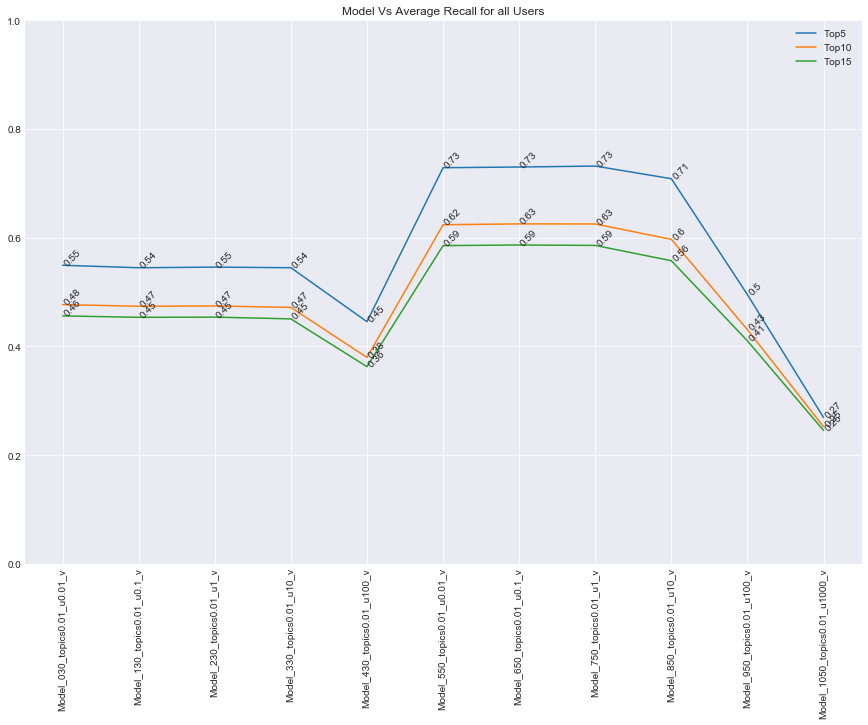

In [71]:
series_loc = AllData_test_run_pivot_df_Original.columns.get_loc("The Big Bang Theory")
avg_recall_df = pd.DataFrame(result_df[result_df.columns[result_df.columns != 'watched']].mean().reset_index())
avg_recall_df_5 = pd.DataFrame(result_df_5[result_df_5.columns[result_df_5.columns != 'watched']].mean().reset_index())
avg_recall_df_15 = pd.DataFrame(result_df_15[result_df_15.columns[result_df_15.columns != 'watched']].mean().reset_index())

avg_recall_df.columns = ['name','sum']
avg_recall_df_5.columns = ['name','sum']
avg_recall_df_15.columns = ['name','sum']

original_watchers = len(np.where(np.array(AllData_test_run_pivot_df_Original.iloc[:,series_loc])>0.0)[0])
avg_recall_df['original'] = [original_watchers for i in range(len(avg_recall_df))]
avg_recall_df_5['original'] = [original_watchers for i in range(len(avg_recall_df_5))]
avg_recall_df_15['original'] = [original_watchers for i in range(len(avg_recall_df_15))]
# avg_recall_df['index_column'] = [i[:len(i)-5] if  i[len(i)-5:len(i)-4] == '_'  else  i[:len(i)-6]  for i in avg_recall_df.name ]
plt.figure(figsize = (15,10))
plt.style.use('seaborn-darkgrid')
plt.plot('name','sum',data = avg_recall_df_5,label = 'Top5')
for i,j in zip(range(len(avg_recall_df_5.name)),avg_recall_df_5['sum']):
    plt.annotate(str(round(j,2)),xy=(i,j), rotation = 45)
plt.plot('name','sum',data = avg_recall_df, label = 'Top10')
for i,j in zip(range(len(avg_recall_df.name)),avg_recall_df['sum']):
    plt.annotate(str(round(j,2)),xy=(i,j), rotation = 45)
plt.plot('name','sum',data = avg_recall_df_15,label ='Top15')
for i,j in zip(range(len(avg_recall_df_15.name)),avg_recall_df_15['sum']):
    plt.annotate(str(round(j,2)),xy=(i,j), rotation = 45)
plt.title("Model Vs Average Recall for all Users")
plt.xticks(rotation = 90)
plt.ylim([0,1])
plt.legend()

Text(0, 0.5, 'Recall')

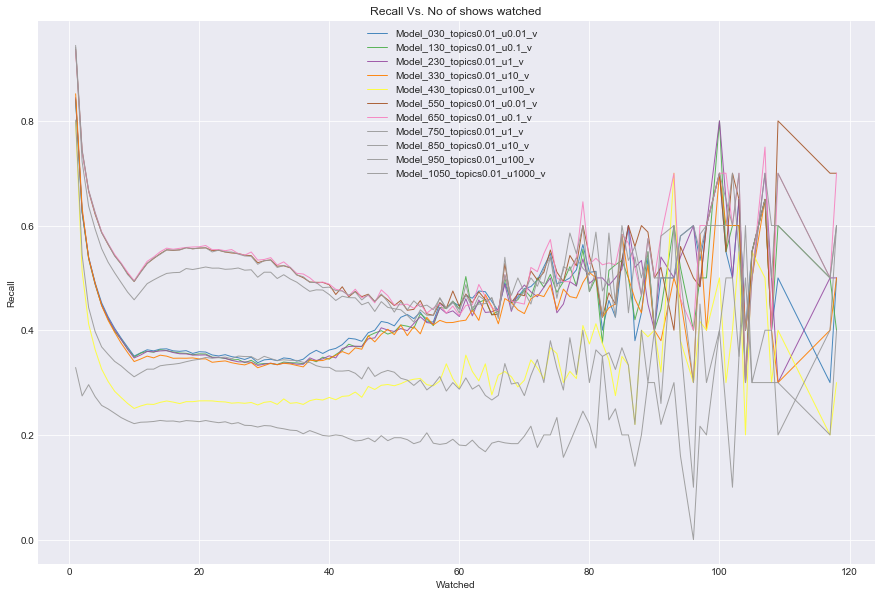

In [72]:
# style
plt.style.use('seaborn-darkgrid')

# create a color palette
palette = plt.get_cmap('Set1')
# plt.rcParams['agg.path.chunksize'] = 10000
plt.figure(figsize=(15,10))

num=0
for column in result_df.columns[1:]:
    num+=1
    res_df = result_df[['watched',column]].groupby('watched').mean().reset_index()
    plt.plot(res_df['watched'], res_df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
plt.legend()
plt.title('Recall Vs. No of shows watched') 
plt.xlabel('Watched')
plt.ylabel('Recall')

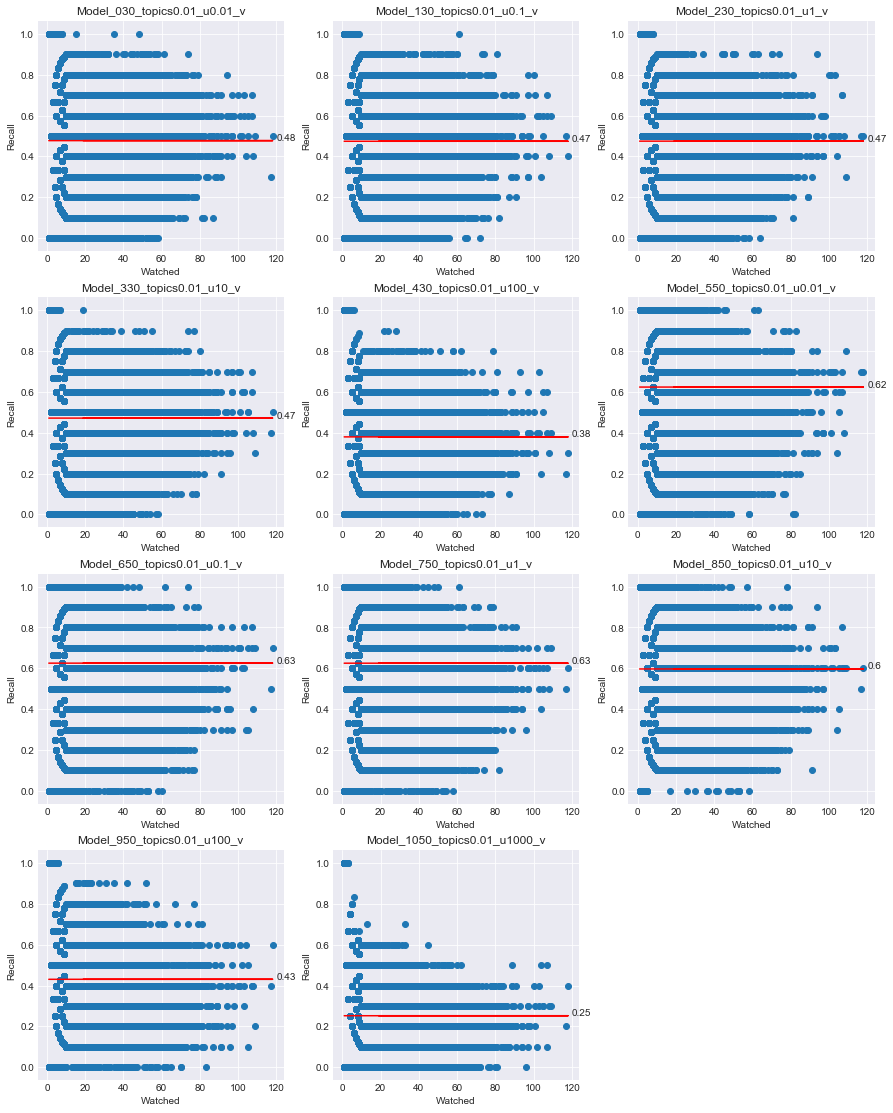

In [86]:
plt.figure(figsize=(15,50))
plt.title('Recall graphs by Model')
for i in range(len(result_array)):
    plt.subplot(10,3,i+1)
    plt.xlabel('Watched')
    plt.ylabel('Recall') 
    model_string = 'Model_'+str(i)+\
                    str(combination_array[i][0])+"_topics"+\
                    str(combination_array[i][1])+"_u"+\
                    str(combination_array[i][2])+"_v"
#     result_df[['watched',model_string]].plot(x= 'watched', y = model_string)
    plt.scatter(x= 'watched', y = model_string,data=result_df)
    mean_val  = np.mean(result_df[model_string])
    plt.plot(result_df['watched'],[mean_val for i in range(len(result_df['watched']))], 'r-')
    plt.text(120, mean_val,str(round(mean_val,2)))
    plt.title(model_string)

In [74]:
# present_list = []
def calculate_present_or_not(inp_original_arr,inp_predicted_arr,inp_threshold,inp_series_loc) :

    def present_calculations(original_arr,predicted_arr,threshold,present_list,series_loc): 
        for i in range(len(original_arr)):
            rank_10 = np.argsort(original_arr[i,:])[-threshold:]
            if (predicted_arr[i,series_loc] > np.min(predicted_arr[i,:][rank_10])) and (original_arr[i,series_loc] > 0.0):
                present_list.append(1)
            else:
                present_list.append(0)
            
    import multiprocessing
    procs = 1   # Number of processes to create
    manager = multiprocessing.Manager()
    present_list = manager.list()
    jobs = []
        # recall_list = list()
    for i in range(0, procs):
        process = multiprocessing.Process(target=present_calculations,args=(np.array(inp_original_arr),inp_predicted_arr,inp_threshold,present_list,inp_series_loc))
        jobs.append(process)
    for j in jobs:
        j.start()
    for j in jobs:
        j.join()
    print("List processing complete.")
    return present_list

In [75]:
def generate_present_or_not(n_top, series_location,dataframe):
    for i in range(len(result_array)):
        model_string = 'Model_'+str(i)+\
                    str(combination_array[i][0])+"_topics"+\
                    str(combination_array[i][1])+"_u"+\
                    str(combination_array[i][2])+"_v"
        column_name  = model_string+'_Top'+str(n_top)
        dataframe[column_name] = calculate_present_or_not(AllData_test_run_pivot_df_Original,result_array[i],n_top,series_location)

In [76]:
present_or_not_df = pd.DataFrame({"watched":watched})
series_loc = AllData_test_run_pivot_df_Original.columns.get_loc("The Big Bang Theory")
generate_present_or_not(5, series_loc,present_or_not_df)
generate_present_or_not(10, series_loc,present_or_not_df)
generate_present_or_not(15, series_loc,present_or_not_df)

List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.
List processing complete.


In [77]:
present_or_not_df.head()

,watched,Model_030_topics0.01_u0.01_v_Top5,Model_130_topics0.01_u0.1_v_Top5,Model_230_topics0.01_u1_v_Top5,Model_330_topics0.01_u10_v_Top5,Model_430_topics0.01_u100_v_Top5,Model_550_topics0.01_u0.01_v_Top5,Model_650_topics0.01_u0.1_v_Top5,Model_750_topics0.01_u1_v_Top5,Model_850_topics0.01_u10_v_Top5,...,Model_130_topics0.01_u0.1_v_Top15,Model_230_topics0.01_u1_v_Top15,Model_330_topics0.01_u10_v_Top15,Model_430_topics0.01_u100_v_Top15,Model_550_topics0.01_u0.01_v_Top15,Model_650_topics0.01_u0.1_v_Top15,Model_750_topics0.01_u1_v_Top15,Model_850_topics0.01_u10_v_Top15,Model_950_topics0.01_u100_v_Top15,Model_1050_topics0.01_u1000_v_Top15
0,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,10,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,1,1,1
3,4,0,0,0,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


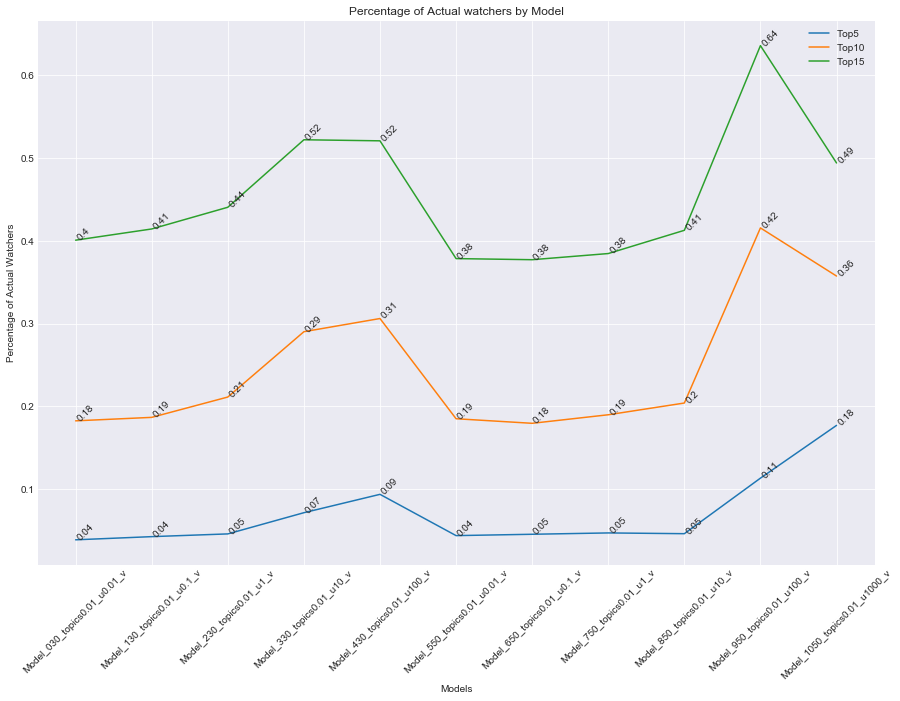

In [87]:
final_df = pd.DataFrame(present_or_not_df[present_or_not_df.columns[present_or_not_df.columns != 'watched']].sum().reset_index())
final_df.columns = ['name','sum']
original_watchers = len(np.where(np.array(AllData_test_run_pivot_df_Original.iloc[:,series_loc])>0.0)[0])
final_df['original'] = [original_watchers for i in range(len(final_df))]
final_df['index_column'] = [i[:len(i)-5] if  i[len(i)-5:len(i)-4] == '_'  else  i[:len(i)-6]  for i in final_df.name ]

top5_data = [name_val.endswith('_Top5') for name_val in final_df.name]
top10_data = [name_val.endswith('_Top10') for name_val in final_df.name]
top15_data = [name_val.endswith('_Top15') for name_val in final_df.name]

final_df['pct'] = final_df['sum']/final_df['original']
final_top5_data = final_df[top5_data].reset_index()
final_top10_data = final_df[top10_data].reset_index()
final_top15_data = final_df[top15_data].reset_index()

plt.figure(figsize = (15,10))
plt.title('Percentage of Actual watchers by Model')
plt.plot('index_column', 'pct' ,data=final_top5_data,label = 'Top5')
plt.plot('index_column', 'pct' ,data=final_top10_data,label = 'Top10')
plt.plot('index_column', 'pct' ,data=final_top15_data,label = 'Top15')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.ylabel('Percentage of Actual Watchers') 
plt.legend()        

for i,j in zip(range(len(final_top5_data.index_column)),final_top5_data['pct']):
    plt.annotate(str(round(j,2)),xy=(i,j),rotation=45)

for i,j in zip(range(len(final_top10_data.index_column)),final_top10_data['pct']):
    plt.annotate(str(round(j,2)),xy=(i,j),rotation=45)

for i,j in zip(range(len(final_top15_data.index_column)),final_top15_data['pct']):
    plt.annotate(str(round(j,2)),xy=(i,j),rotation=45)